In [9]:
import json
def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

data = load_json("/mnt/workspace/Projects/CS6223/data/needles/needle.json")

In [10]:
data[0]

{'needle': 'A large orange butterfly flutters gracefully above the vibrant lavender, casting delicate shadows on the cobblestone path beneath a bright blue sky.',
 'retrieval_question': 'What does a large orange butterfly do as it flutters above the vibrant lavender?',
 'index': 0,
 'image_needle': '1730618303864116089.png'}

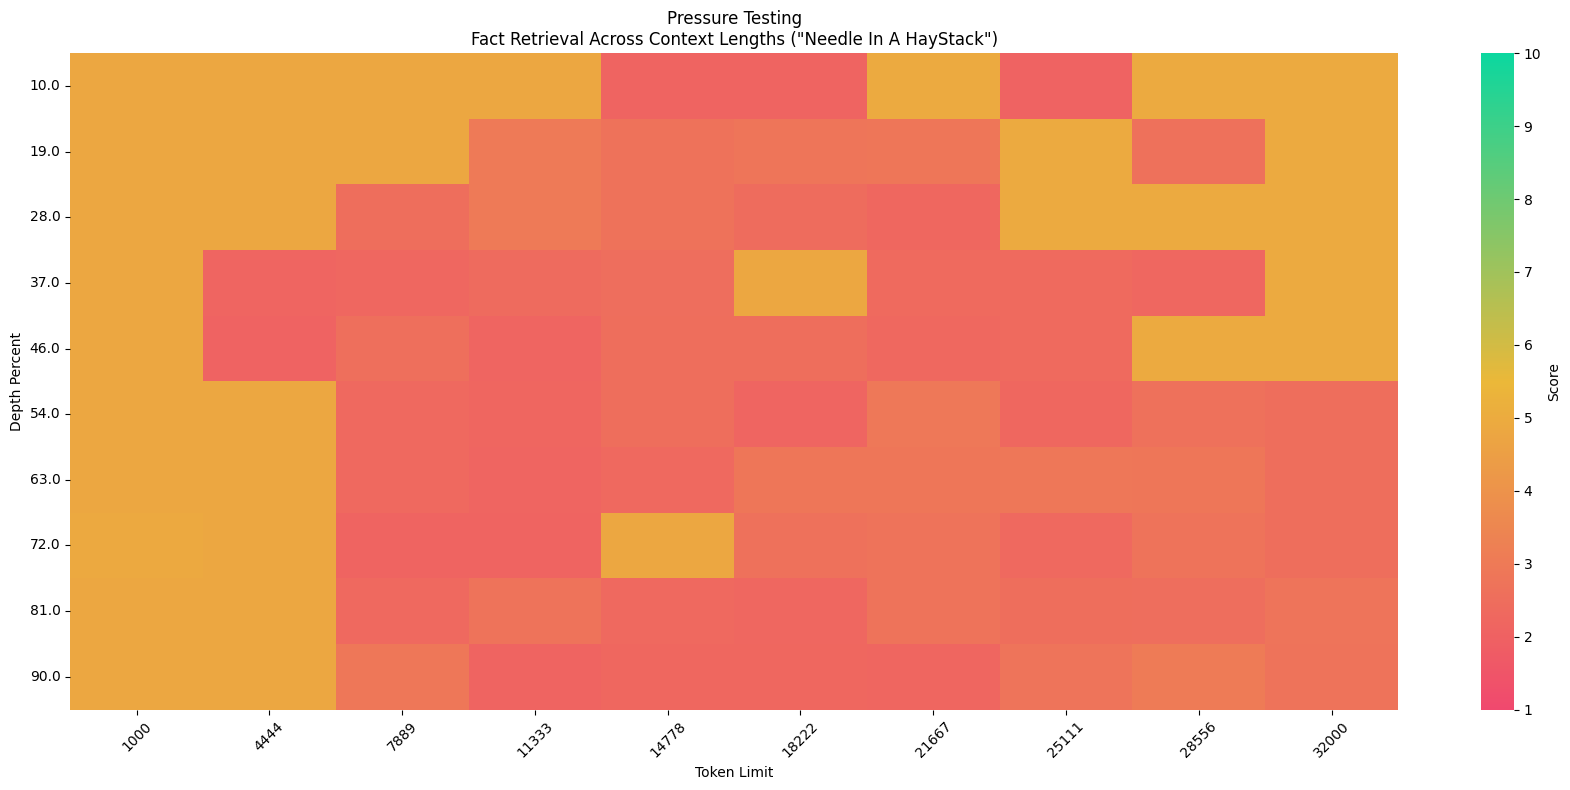

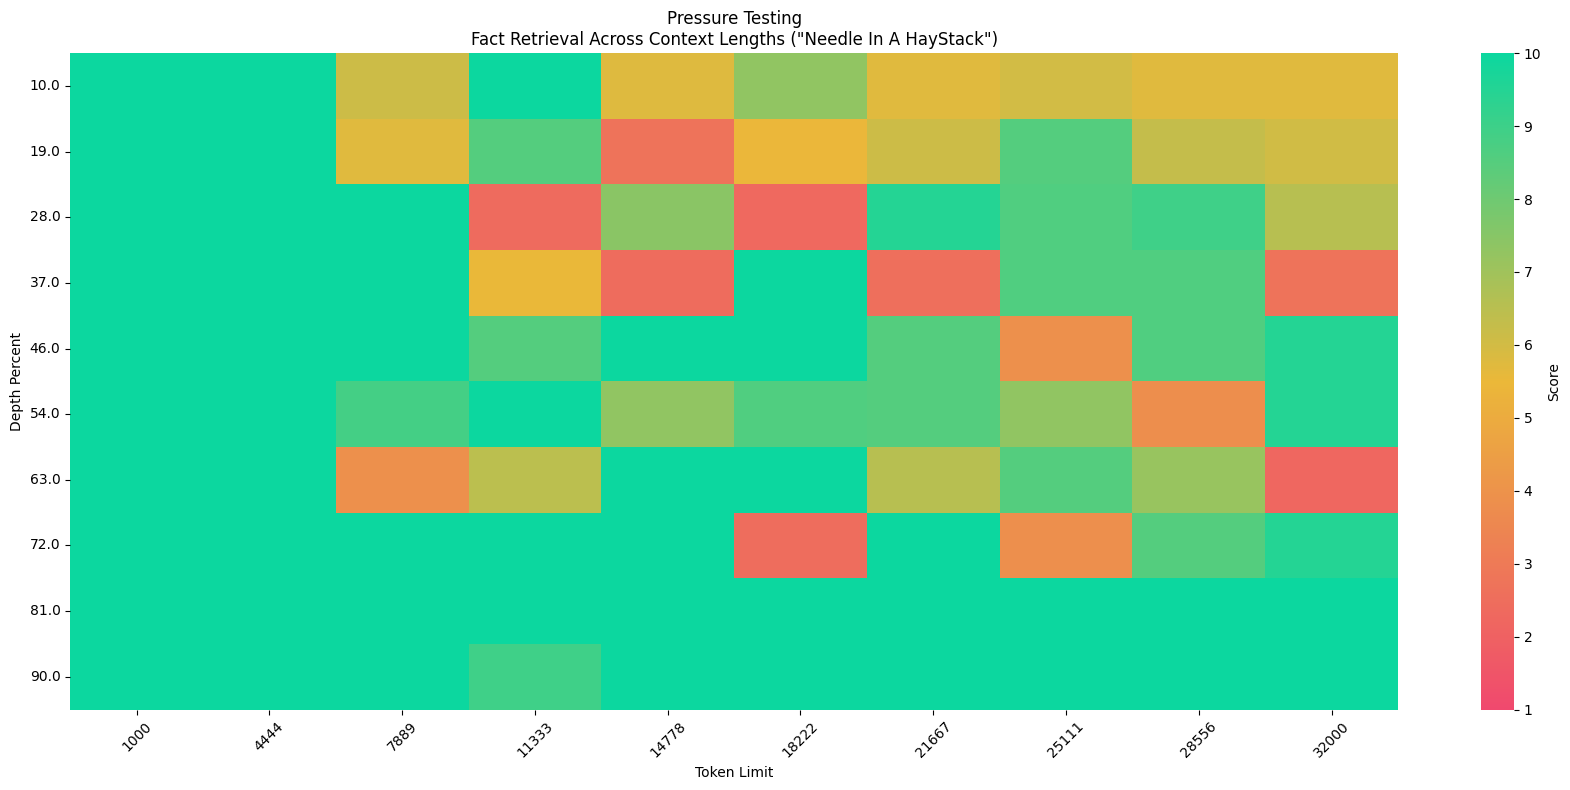

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
import os
import re
import glob


# Using glob to find all json files in the directory
# json_files = glob.glob(f"results/*.json")
json_files = ["/mnt/workspace/Projects/CS6223/eval/qwen_eval/1/image.json", "/mnt/workspace/Projects/CS6223/eval/qwen_eval/1/text.json"]
if not os.path.exists('vis'):
    os.makedirs('vis')

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    # List to hold the data
    data = []

    with open(file, 'r') as f:
        json_data = json.load(f)
        
        for k in json_data:
            pattern = r"_len_(\d+)_"
            match = re.search(pattern, k)
            context_length = int(match.group(1)) if match else None

            pattern = r"depth_(\d+)"
            match = re.search(pattern, k)
            document_depth = eval(match.group(1))/100 if match else None

            score = json_data[k]['score'][-1]*10

            # Appending to the list
            data.append({
                "Document Depth": document_depth,
                "Context Length": context_length,
                "Score": score
            })

    # Creating a DataFrame
    df = pd.DataFrame(data)

    pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
    pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
    
    # Create a custom colormap. Go to https://coolors.co/ and pick cool colors
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

    # Create the heatmap with better aesthetics
    plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
    sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
        cbar_kws={'label': 'Score'},
        vmin=1,
        vmax=10,
    )

    # More aesthetics
    plt.title(f'Pressure Testing\nFact Retrieval Across Context Lengths ("Needle In A HayStack")')  # Adds a title
    plt.xlabel('Token Limit')  # X-axis label
    plt.ylabel('Depth Percent')  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area
    # Show the plot
    plt.savefig(f"vis/{file.split('/')[-1].replace('.json', '')}.png")
